<a href="https://colab.research.google.com/github/Nicolekara/CarPredict/blob/main/car_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:

df = pd.read_csv('/content/dataset.csv')

df.head()


,manufactor,Year,model,Hand,Gear,capacity_Engine,Engine_type,Prev_ownership,Curr_ownership,Area,City,Price,Pic_num,Cre_date,Repub_date,Description,Color,Km,Test,Supply_score
0,יונדאי,2015,i35,2,אוטומטית,1600,בנזין,פרטית,פרטית,רעננה - כפר סבא,רעננה,51000.0,2.0,11/07/2023,11/07/2023,['רכב שמור בקנאות\nמוכרת עקב קבלת רכב חברה'],כחול כהה מטאלי,144000,NaN,NaN
1,ניסאן,2018,ניסאן מיקרה,1,אוטומטית,1200,בנזין,פרטית,פרטית,מושבים בשרון,אבן יהודה,49000.0,0.0,06/04/2022,22/05/2022,['שמורה כל התוספות'],כחול בהיר,69000,NaN,NaN
2,סוזוקי,2010,סוזוקי סוויפט,1,אוטומטית,1450,בנזין,NaN,NaN,רמת,רמת,22500.0,1.0,29/10/2022,29/10/2022,['רכב במצב מתוחזק ברמה גבוהה טסט עד אפריל 2023'],NaN,145000,NaN,NaN
3,טויוטה,2016,אוריס,1,טיפטרוניק,1600,בנזין,פרטית,פרטית,נס ציונה - רחובות,רחובות,63000.0,5.0,16/05/2024,16/05/2024,['אוטו במצב חדש!! שמור בקנאות!! נהג יחיד מטופל...,אפור מטאלי,27300,NaN,NaN
4,קיה,2012,פיקנטו,1,אוטומטית,1248,בנזין,NaN,NaN,"ראשל""צ והסביבה",ראשון לציון,37000.0,1.0,13/06/2022,13/06/2022,['שמור'],NaN,70000,NaN,4.0


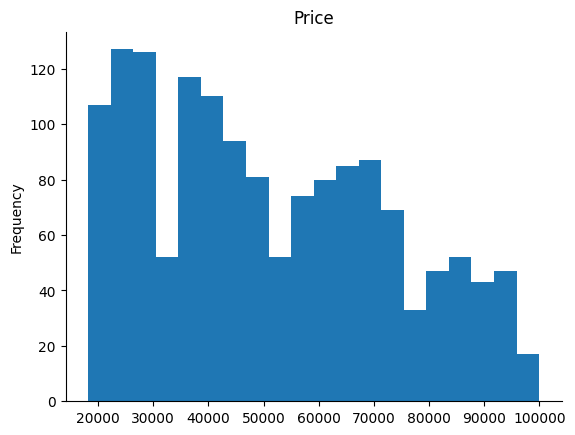

In [ ]:
# @title Price

from matplotlib import pyplot as plt
df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Prev_ownership   771 non-null    object 
 8   Curr_ownership   772 non-null    object 
 9   Area             1351 non-null   object 
 10  City             1500 non-null   object 
 11  Price            1500 non-null   float64
 12  Pic_num          1476 non-null   float64
 13  Cre_date         1500 non-null   object 
 14  Repub_date       1500 non-null   object 
 15  Description      1500 non-null   object 
 16  Color            730 non-null    object 
 17  Km            

In [ ]:

# פונקציה שתבצע את האיחוד בין העמודות
def combine_ownership(row):
 # רשימת ערכים שלא פרטי
  non_private_values = ['השכרה', 'חברה', 'ליסינג', 'מונית', 'ממשלתי']

    # בדיקה אם בעמודה Prev_ownership הערך הוא לא פרטי
  if row['Prev_ownership'] in non_private_values:
        return False

    # בדיקה אם בעמודה Curr_ownership הערך הוא לא פרטי
  if row['Curr_ownership'] in non_private_values:
        return False

    # אחרת, הערך הוא פרטי
  return True

# פונקציה להמרת ערכי Gear לערכים בינאריים
def convert_gear(gear):
    non_manual_values = df.Gear.unique().tolist()
    non_manual_values.remove('ידנית')

    manual_values = ['ידנית']

    if gear in non_manual_values:
        return False
    else:
        return True
# פונקציה להסרת שם היצרן מהמודל
def remove_manufactor_from_model(row):
    manufactor = str(row['manufactor']).strip()
    model = str(row['model']).strip()

    if manufactor in model:
        # מחיקת שם היצרן מהמודל והסרת רווחים מיותרים
        return model.replace(manufactor, '').strip()
    else:
        return model

def prepare_data(df):
  df = df.drop_duplicates().reset_index(drop=True)
# הסבת כל הערכים למחרוזות והסרת פסיקים
  df['Km'] = df['Km'].astype(str).str.replace(',', '')
  df['capacity_Engine'] = df["capacity_Engine"].astype(str).str.replace(',', '')

# המרה לערכים מספריים (אם יש ערכים שאינם מספריים הם יהפכו ל-NaN)
  df['Km'] = pd.to_numeric(df['Km'], errors='coerce')
  df["capacity_Engine"] = pd.to_numeric(df['capacity_Engine'], errors='coerce')

# תנאים לשינוי ערכי העמודה
  df.loc[(df['Km'] > 100) & (df['Km'] < 1000), 'Km'] *= 1000
  df.loc[df['Km'] > 1000000, 'Km'] /= 10

# מילוי ערכים מתחת ל-100 בממוצע הקבוצתי לפי עמודת השנה עם transform
  df['Km'] = df.groupby('Year')['Km'].transform(lambda x: x.where(x >= 100, x.mean()))


# הוספת העמודה המאוחדת ל-DataFrame
  df['IsPrivate'] = df.apply(combine_ownership, axis=1)
  df = df.drop(columns=['Prev_ownership', 'Curr_ownership'])

# יצירת מילון להחלפת הערכים בעמודה Engine_type
  engine_type_mapping = {
    'דיזל': 'דיזל',
    'טורבו דיזל': 'דיזל',
    'היבריד': 'היברידי',
    'היברידי': 'היברידי',
    None: 'דיזל',  # לטיפול בערכים ריקים (NA)
    '': 'דיזל'    # לטיפול בערכים ריקים (מחרוזות ריקות)
}

# החלפת הערכים בעמודה
  df['Engine_type'] = df['Engine_type'].replace(engine_type_mapping)
# המרת הערכים ישירות בעמודת Gear
  df['IsManual'] = df['Gear'].apply(convert_gear)

  df.manufactor = df.manufactor.replace('Lexsus' , 'לקסוס')
# החלפת הערכים בעמודת model
  df['model'] = df.apply(remove_manufactor_from_model, axis=1)
  return df


In [ ]:
df = prepare_data(df)

In [ ]:
numeric_col = ['Year', 'Hand', 'Km']
cat_col=["Engine_type","Area",'model']
binary_col = ['IsPrivate', 'IsManual']
y_col = 'Price'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# הגדרת רשימות המשתנים
numeric_col = ['Year', 'Hand', 'Km']
cat_col = ["Engine_type",  'model']
binary_col = ['IsPrivate', 'IsManual']
y_col = 'Price'
# הגדרת טרנספורמציות עבור כל סוג משתנה
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore',drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_col),
        ('cat', categorical_transformer, cat_col),
        ('bin', 'passthrough', binary_col)
    ])

# יצירת ה-Pipeline המלא
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# החלת ה-Pipeline על הנתונים
X = df.drop(columns=[y_col])
X = pipeline.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df[y_col], test_size=0.2, random_state=22)

# החלת ה-Pipeline על נתוני האימון בלבד
X_train_transformed = pipeline.fit_transform(X_train)

# החלת ה-Pipeline על נתוני הבדיקה (ללא התאמה)
X_test_transformed = pipeline.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:

# הגדרת רשת של היפר-פרמטרים
param_grid = {
    'alpha': [0.001, 0.00005, 0.1, 1],
    'l1_ratio': [ 0.5,0.6,0.7]
}

# יצירת מודל אלסטי נט
elastic_net = ElasticNet()

# חיפוש גריד עבור ההיפר-פרמטרים הטובים ביותר באמצעות אימות צולב
grid_search = GridSearchCV(elastic_net, param_grid, cv=10)
grid_search.fit(X, df[y_col])

# בחירת המודל הטוב ביותר
best_model = grid_search.best_estimator_

# חיזוי על נתוני הבדיקה
y_pred = best_model.predict(X)

# הערכת המודל
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
print("Best model:", best_model)


print("Mean Squared Error:", mean_squared_error(df[y_col], y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174068149.05940247, tolerance: 60918826.144114114
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160240464.58543396, tolerance: 61401271.27937577
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381110199.47532654, tolerance: 61584235.20709346
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:589: Conv

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.6}
Best score: 0.6026678204006407
Best model: ElasticNet(alpha=0.001, l1_ratio=0.6)
Mean Squared Error: 95647002.44179416


In [ ]:
# חיזוי על נתוני הבדיקה
#y_pred = best_model.predict(X_test_transformed)

# חישוב מדדי הערכה
mse = mean_squared_error(df[y_col], y_pred)
mae = mean_absolute_error(df[y_col], y_pred)
r2 = r2_score(df[y_col], y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:",  r2)

Root Mean Squared Error: 9779.928549932978
Mean Squared Error: 95647002.44179416
Mean Absolute Error: 7106.64786855319
R-squared: 0.8062402008192595


In [ ]:
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1]\
                       .named_steps['onehot'].get_feature_names_out(cat_col)
# חיבור שמות הפיצ'רים המקוריים לשמות החדשים
all_feature_names = list(numeric_col) + list(feature_names) + binary_col


In [ ]:
#feature_names = X.columns  # שמות המאפיינים
coefficients = best_model.coef_

# יצירת DataFrame להצגה טובה יותר
coef_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefficients})
coef_df

,feature,coefficient
0,Year,12853.953615
1,Hand,-745.028489
2,Km,-5135.283115
3,Engine_type_גז,-588.654080
4,Engine_type_דיזל,1415.888314
...,...,...
257,model_ריו,-17197.397447
258,model_שירוקו,8215.285639
259,model_שרמנט,-3607.501712
260,IsPrivate,6180.712527
